### Temporal ordering of embryos
Notebook to order the single embryos on a time axis. Transcriptional ranking of the embryos is saved in
*data/embexe.transcriptional_ranks.tsv* at the end of the notebook.

In [1]:
setwd(here::here())

In [2]:
library("slanter")
library("metacell")
library("dplyr")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
scdb_init("scrna_db/",force_reinit = T)
scfigs_init('figs')

initializing scdb to scrna_db/



In [4]:
emb_nominal_time = read.csv('data/embexe.morphology_nominal_time.csv',stringsAsFactors = F)
head(emb_nominal_time)

,embryo,embryo_nominal_time,morphological_stage,morphological_rank
,<chr>,<dbl>,<chr>,<int>
1,EXE26_pooled,4.5,pre implantation,1
2,EXE27_pooled,4.5,pre implantation,2
3,EXE17_e1,5.5,pre cavitated/cavitated,3
4,EXE7_e5,5.5,pre cavitated/cavitated,4
5,EXE4_M1e1,5.5,pre cavitated/cavitated,5
6,EXE7_e8,5.5,pre cavitated/cavitated,6


In [5]:
mat = scdb_mat("embexe_with_e45")
mc = scdb_mc("embexe_with_e45")

mc@color_key

,group,color,gene
,<chr>,<chr>,<chr>
1,Forebrain/Midbrain/Hindbrain,#647A4F,
2,Rostral neural plate,#649146,
3,Surface ectoderm,#f7f79e,
4,Neural crest,#C3C388,
5,Caudal neural plate,#354E23,
6,Neural tube/Floor plate,#CDE088,
7,Definitive ectoderm,#90BF75,
8,Tail bud - neural,#8e7e59,
9,Epiblast,#635547,


In [6]:
excluded_mcs = c(1:ncol(mc@e_gc))[!(mc@colors %in% mc@color_key$color[1:40])]
df_cells = data.frame(cell = names(mc@mc),embryo = mat@cell_metadata[names(mc@mc),"embryo"],mc = mc@mc,stringsAsFactors = F)
df_cells = left_join(df_cells,emb_nominal_time,by = "embryo")

f = !is.na(df_cells$embryo_nominal_time)

mc_time = tapply(df_cells$embryo_nominal_time[f],df_cells$mc[f],mean)

table(df_cells$embryo_nominal_time[f])


  4.5   5.5     6  6.25   6.5     7   7.5  7.75     8  8.25   8.5 
  114   302   439  1630  8432  3849  5353  8317 18232  3527  4751 

In [7]:
embryo_time = tapply(mc_time[mc@mc],mat@cell_metadata[names(mc@mc),"embryo"],mean)
embryo_time = sort(embryo_time)
emb_time = data.frame(embryo = names(embryo_time),embryo_mean_time = embryo_time,rank = c(1:length(embryo_time)))

emb_time = left_join(emb_time,emb_nominal_time,by = "embryo")

In [8]:
sum(is.na(emb_time$embryo_mean_time))
head(emb_time)

[1] 0

,embryo,embryo_mean_time,rank,embryo_nominal_time,morphological_stage,morphological_rank
,<chr>,<dbl>,<int>,<dbl>,<chr>,<int>
1,EXE26_pooled,4.500000,1,4.5,pre implantation,1
2,EXE27_pooled,4.500000,2,4.5,pre implantation,2
3,EXE4_M2e1,5.775455,3,5.5,pre cavitated/cavitated,8
4,EXE17_e4,5.778226,4,5.5,pre cavitated/cavitated,9
5,EXE4_M1e2,5.782126,5,5.5,pre cavitated/cavitated,13
6,EXE4_M1e3,5.790850,6,NA,NA,NA


In [9]:
generate_emb_emb_similarity_matrix = function(mat_id,graph_id,mc_id,included_embryos = NULL,excluded_mcs = NULL,number_of_neighbors = 50,remove_diagonal = TRUE) {
  

  
  cgraph = scdb_cgraph(graph_id)
  mat = scdb_mat(mat_id)
  mc = scdb_mc(mc_id)
  
  cls_a = names(mc@mc)[!is.na(mat@cell_metadata[names(mc@mc),"embryo"])]
  cls_a = intersect(cls_a,colnames(mat@mat))
  
  if(is.null(included_embryos)) {
    included_embryos = unique(mat@cell_metadata[cls_a,"embryo"])
  }
  included_embryos = intersect(included_embryos,unique(mat@cell_metadata[cls_a,"embryo"]))
  
  included_mcs =  setdiff(c(1:ncol(mc@e_gc)),excluded_mcs)
  included_cells = cls_a[(mc@mc[cls_a] %in% included_mcs) & (mat@cell_metadata[cls_a,"embryo"] %in% included_embryos)]
  
  
  cell_to_embryo = as.character(mat@cell_metadata[included_cells,"embryo"])
  names(cell_to_embryo) = included_cells
  
  # prepare list of edges
  included_edges = cgraph@edges[(( cgraph@edges$mc1 %in% included_cells ) & ( cgraph@edges$mc2 %in% included_cells )),]
  included_edges$mc1 = factor(x = as.character(included_edges$mc1),levels = included_cells)
  included_edges$mc2 = factor(x = as.character(included_edges$mc2),levels = included_cells)
  included_edges$emb1 = factor(cell_to_embryo[included_edges$mc1],levels = included_embryos)
  included_edges$emb2 = factor(cell_to_embryo[included_edges$mc2],levels = included_embryos)
  
  # exclude embryo self edges
  f = included_edges$emb1 != included_edges$emb2
  included_edges = included_edges[f,]
  
  # number of outgoing edges from cell1 should be smaller than number_of_neighbors
  # filter edges with highest rank
  
  f_edges = tapply(X = c(1:nrow(included_edges)),INDEX = included_edges$mc1,function(n_ind) {
    
    if(length(n_ind) > number_of_neighbors) {
      n_ind = n_ind[order(-included_edges$w[n_ind])]
      n_ind = n_ind[1:number_of_neighbors]
    }
    return(n_ind)
  })
  f_edges = unlist(f_edges)
  
  included_edges = included_edges[f_edges,]
  
  # generate similarity matrix by counting edges between two embryos
  mat_emb_neighbors = table(included_edges$emb1,
                            included_edges$emb2)
  
  mat_emb_neighbors = as.matrix(as.data.frame.matrix(mat_emb_neighbors))
  
  #mat_emb_neighbors = 1/2*(mat_emb_neighbors + t(mat_emb_neighbors))
  
  embryo_weight = table(mat@cell_metadata[included_cells,"embryo"])
  embryo_weight = embryo_weight[rownames(mat_emb_neighbors)]
  
  # Normalize each column by the total number of cells this embryo has.
  mat_emb_neighbors = t(t(mat_emb_neighbors)/as.numeric(embryo_weight))
  #mat_emb_neighbors = mat_emb_neighbors/as.numeric(embryo_weight)
  
  
  if(remove_diagonal) {
    diag(mat_emb_neighbors) = 0
  }
  mat_emb_neighbors = mat_emb_neighbors/rowSums(mat_emb_neighbors)
  mat_emb_neighbors = 1/2*(mat_emb_neighbors + t(mat_emb_neighbors))
  
  
  return(mat_emb_neighbors)
} 

In [10]:
sim_mat_correct_for_batch_effects = function(ee_mat,embryo_coarse_time,embryo_batch) {
  
  embryo_coarse_time = embryo_coarse_time[names(embryo_coarse_time) %in% rownames(ee_mat)]
  embryo_batch = embryo_batch[names(embryo_batch) %in% rownames(ee_mat)]
  
  batches = unique(embryo_batch)
  
  for (batch in batches) {
    
    emb_batch = names(embryo_batch)[embryo_batch == batch]
    
    time_points = unique(embryo_coarse_time[emb_batch])
    other_embryos = setdiff(names(embryo_coarse_time)[embryo_coarse_time %in% time_points],emb_batch)
    
    intra_batch_sim = sum(ee_mat[emb_batch,emb_batch])/(length(emb_batch)*(length(emb_batch)-1))
    inter_batch_sim = sum(ee_mat[emb_batch,other_embryos])/(length(emb_batch)*length(other_embryos))
    
    if((length(emb_batch) > 1) & (intra_batch_sim > 0) & (length(other_embryos) > 1)) {
      ee_mat[emb_batch,emb_batch] = ee_mat[emb_batch,emb_batch]/intra_batch_sim*inter_batch_sim
    }
   
  }
  
  return(ee_mat)
}



In [11]:
sim_mat_reorder_rows_and_cols = function(ee_mat) {
  
  count = 0
  n_emb = ncol(ee_mat)
  n_iter_max = 1000
  n_iter = 0
  delta_count = 1
  
  e_order = c(1:nrow(ee_mat))
  
  
  while ((n_iter < n_iter_max)  & (delta_count > 0) ) {
    
    old_count = count
    n_iter = n_iter + 1
    
    for(i in 1:(n_emb-1)) {
      
      #embryo = embryos[i]
      #next_embryo = embryos[i+1]
      
      if (i == 1) {
        #row_2 = sum(ee_mat[embryo,(i+2):n_emb]) - sum(ee_mat[next_embryo,(i+2):n_emb])
        #col_2 = sum(ee_mat[(i+2):n_emb,embryo]) - sum(ee_mat[(i+2):n_emb,next_embryo])
        row_2 = sum(ee_mat[i,(i+2):n_emb]) - sum(ee_mat[i+1,(i+2):n_emb])
        col_2 = sum(ee_mat[(i+2):n_emb,i]) - sum(ee_mat[(i+2):n_emb,i+1])
        if (row_2 +col_2 > 0) {
          #embryos[i] = next_embryo
          #embryos[i+1] = embryo
          e_order[c(i,i+1)] = e_order[c(i+1,i)]
          ee_mat[c(i,i+1),] = ee_mat[c(i+1,i),]
          ee_mat[,c(i,i+1)] = ee_mat[,c(i+1,i)]
          #ee_mat = ee_mat[embryos,embryos]
          count = count + 1 
        }
      } else if (i == (n_emb-1)) {
        #row_1 = sum(ee_mat[embryo,1:(i-1)]) - sum(ee_mat[next_embryo,1:(i-1)])
        #col_1 = sum(ee_mat[1:(i-1),embryo]) - sum(ee_mat[1:(i-1),next_embryo])
        row_1 = sum(ee_mat[i,1:(i-1)]) - sum(ee_mat[i+1,1:(i-1)])
        col_1 = sum(ee_mat[1:(i-1),i]) - sum(ee_mat[1:(i-1),i+1])
        if (row_1 + col_1 > 0) {
          #embryos[i] = next_embryo
          #embryos[i+1] = embryo
          #ee_mat = ee_mat[embryos,embryos]
          e_order[c(i,i+1)] = e_order[c(i+1,i)]
          ee_mat[c(i,i+1),] = ee_mat[c(i+1,i),]
          ee_mat[,c(i,i+1)] = ee_mat[,c(i+1,i)]
          count = count + 1 
        }
        
      } else {
        #row_1 = sum(ee_mat[embryo,1:(i-1)]) - sum(ee_mat[next_embryo,1:(i-1)])
        #row_2 = sum(ee_mat[embryo,(i+2):n_emb]) - sum(ee_mat[next_embryo,(i+2):n_emb])
        #col_1 = sum(ee_mat[1:(i-1),embryo]) - sum(ee_mat[1:(i-1),next_embryo])
        #col_2 = sum(ee_mat[(i+2):n_emb,embryo]) - sum(ee_mat[(i+2):n_emb,next_embryo])
        row_1 = sum(ee_mat[i,1:(i-1)]) - sum(ee_mat[i+1,1:(i-1)])
        row_2 = sum(ee_mat[i,(i+2):n_emb]) - sum(ee_mat[i+1,(i+2):n_emb])
        col_1 = sum(ee_mat[1:(i-1),i]) - sum(ee_mat[1:(i-1),i+1])
        col_2 = sum(ee_mat[(i+2):n_emb,i]) - sum(ee_mat[(i+2):n_emb,i+1])
        
        if (row_2 - row_1 + col_2 - col_1 > 0) { 
          #embryos[i] = next_embryo
          #embryos[i+1] = embryo
          #ee_mat = ee_mat[embryos,embryos]
          e_order[c(i,i+1)] = e_order[c(i+1,i)]
          ee_mat[c(i,i+1),] = ee_mat[c(i+1,i),]
          ee_mat[,c(i,i+1)] = ee_mat[,c(i+1,i)]
          count = count + 1 
        }
      }
      
      
    }
    delta_count = count - old_count
    print(delta_count)
  }
  
  colnames(ee_mat) = colnames(ee_mat)[e_order]
  rownames(ee_mat) = colnames(ee_mat)
  
  return(list(mat_reshuffled = ee_mat,final_order = e_order))
}



In [12]:
cells_f = intersect(colnames(mat@mat),names(mc@mc))

mc_vs_emb = table(mc@colors[mc@mc[cells_f]],mat@cell_metadata[cells_f,"embryo"])
mc_vs_emb = mc_vs_emb[mc@color_key$color[1:40],]
embryonic_cells_per_embryo = colSums(mc_vs_emb)

included_embryos = names(embryonic_cells_per_embryo)[embryonic_cells_per_embryo >= 7]

excluded_mcs = c(1:ncol(mc@e_gc))[!(mc@colors %in% mc@color_key$color[1:40])]

init_order_embryos = emb_time$embryo[order(emb_time$embryo_mean_time)]
#init_order_embryos = emb_nominal_time$embryo
included_embryos = init_order_embryos[init_order_embryos %in% included_embryos]

#included_embryos = included_embryos[order(embryo_time[included_embryos])]

In [13]:
ee_mat = generate_emb_emb_similarity_matrix(mat_id = "embexe_with_e45",
                                             graph_id = "embexe",
                                             mc_id = "embexe_with_e45",
                                             included_embryos = included_embryos,
                                             excluded_mcs = excluded_mcs,number_of_neighbors = 10)

In [14]:
sort_date = unique(mat@cell_metadata[names(mc@mc),c("embryo","Sort.Date")])
emb_time = left_join(emb_time,sort_date,by = "embryo")
embryo_coarse_time = emb_time$embryo_nominal_time
names(embryo_coarse_time) = emb_time$embryo
embryo_batch = emb_time$Sort.Date
names(embryo_batch) = emb_time$embryo

In [15]:
table(emb_time$Sort.Date)


 1/13/2020  1/19/2020  1/22/2020  1/30/2020 10/11/2020 10/16/2020 10/24/2019 
         4         10          5          3          3          7          3 
11/11/2019 11/12/2019 11/14/2019  11/2/2020  11/3/2019 12/16/2019 12/18/2019 
         5          5          7          1         18          8          5 
 12/7/2021 13/03/2019   13/10/21 14/02/2019   14/06/20   16/06/20   16/08/20 
         4          6          3          5         10          7          1 
16/12/2019 17/12/2019   18/05/20   19/01/20   2/1/2020  2/11/2020  2/25/2020 
         3         13          7          4          5          3          3 
23/02/2019   23/06/21   26/03/20   27/07/20   27/12/19   29/06/20   30/06/21 
         7          7          5          5          6          1          4 
   30/1/20   4/3/2019  5/27/2019   5/6/2019  7/10/2019   7/3/2019  8/18/2019 
         3          9         37         18         11          8          2 
  8/9/2019  9/12/2018   9/8/2019 
         1         11        

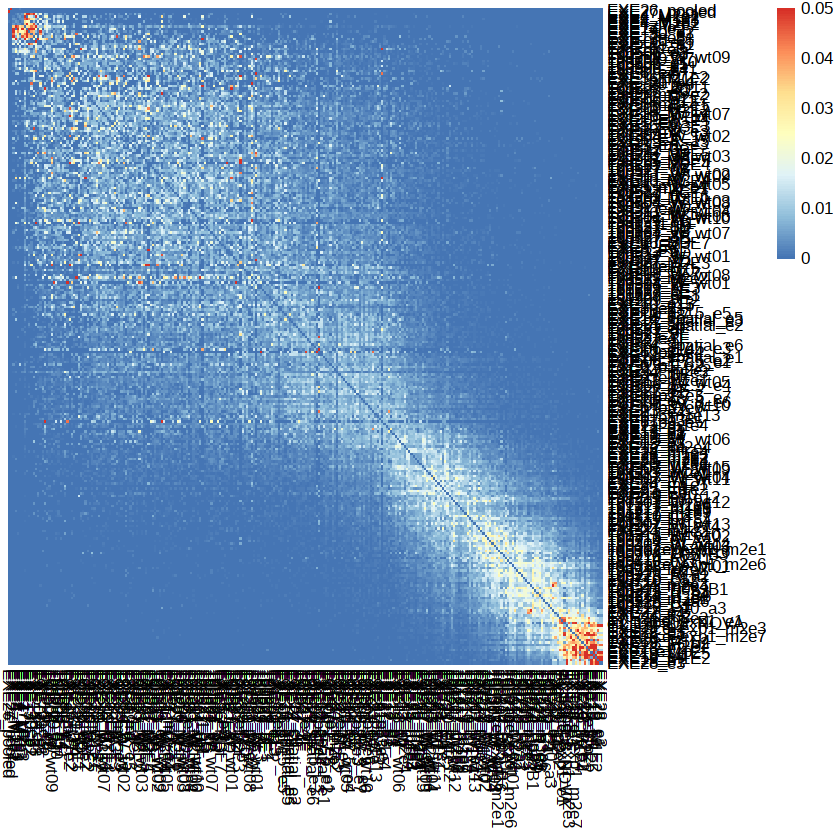

In [16]:
ee_mat_n = sim_mat_correct_for_batch_effects(ee_mat = ee_mat,embryo_coarse_time = embryo_coarse_time,embryo_batch = embryo_batch)
  
pheatmap::pheatmap(mat = pmin(ee_mat_n,0.05),w = 25,h = 25,cluster_rows = F,cluster_cols = F)


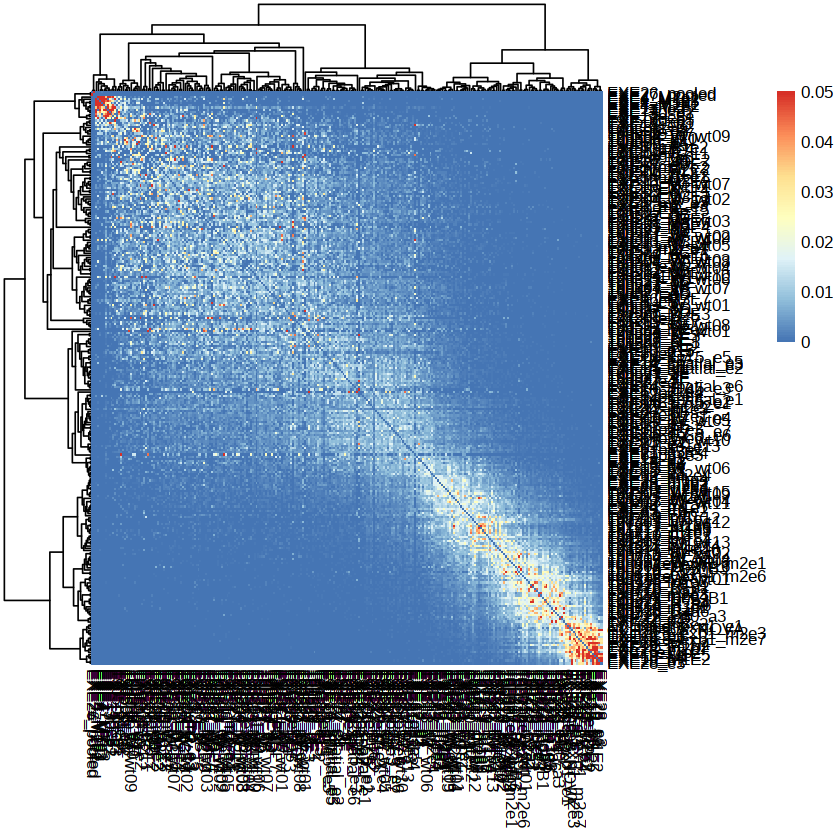

[1] 205
[1] 184
[1] 142
[1] 118
[1] 107
[1] 98
[1] 78
[1] 66
[1] 67
[1] 57
[1] 66
[1] 66
[1] 48
[1] 41
[1] 34
[1] 32
[1] 30
[1] 32
[1] 41
[1] 36
[1] 28
[1] 25
[1] 21
[1] 24
[1] 15
[1] 15
[1] 9
[1] 8
[1] 12
[1] 10
[1] 9
[1] 9
[1] 11
[1] 12
[1] 9
[1] 30
[1] 13
[1] 9
[1] 13
[1] 7
[1] 8
[1] 9
[1] 13
[1] 12
[1] 10
[1] 4
[1] 3
[1] 2
[1] 2
[1] 2
[1] 1
[1] 2
[1] 8
[1] 1
[1] 0


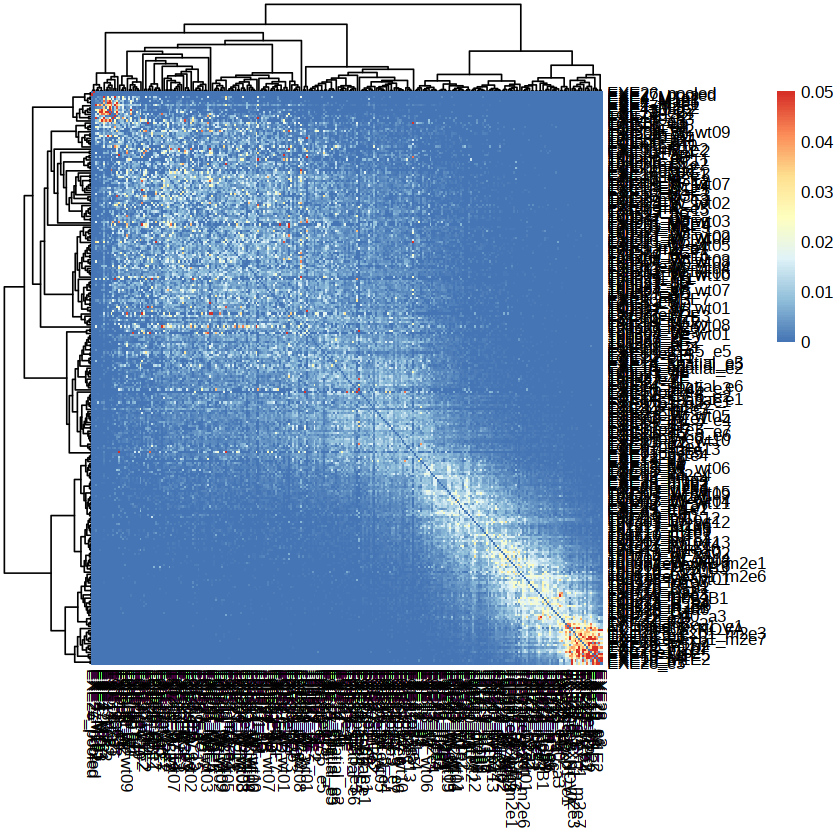

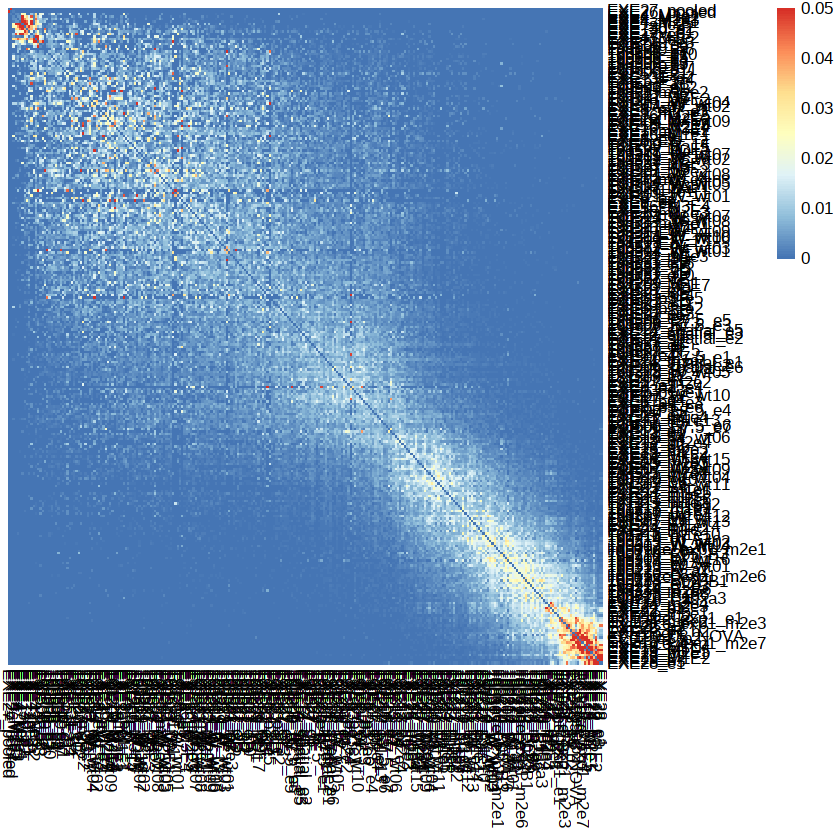

In [17]:
sheatmap(data = pmin(ee_mat,0.05),order_data = ee_mat,same_order = T)
sheatmap(data = pmin(ee_mat_n,0.05),order_data = ee_mat_n,same_order = T)
#ee_mat_n_reordered = sim_mat_reorder_rows_and_cols(ee_mat_n)
#pheatmap::pheatmap(mat = pmin(ee_mat_n_reordered$mat_reshuffle,0.05),w = 25,h = 25,cluster_rows = F,cluster_cols = F)
ee_mat_reordered = sim_mat_reorder_rows_and_cols(ee_mat_n)
pheatmap::pheatmap(mat = pmin(ee_mat_reordered$mat_reshuffle,0.05),w = 25,h = 25,cluster_rows = F,cluster_cols = F)

In [20]:
additional_excluded_embryos = c("e1_190908_NOVA","EXE22_e2","EXE23_E6","EXE23_E5","EXE23_E4","EXE6_p3_e5","EXE6_p2_e4",'190304_W_wt09','181209_R_11','EXE16_M2E4','EXE8_e1')

#barplot(embryonic_cell_types[,additional_excluded_embryos],col = rownames(emb_ct_n),las =2 )

embryos_ranked = rownames(ee_mat_reordered$mat_reshuffled)
embryos_ranked = embryos_ranked[!(embryos_ranked %in% additional_excluded_embryos)]

df_transcriptional_rank = data.frame(embryo = embryos_ranked,transcriptional_rank = c(1:length(embryos_ranked)))
dim(df_transcriptional_rank)


[1] 253   2

In [21]:
write.table(x = df_transcriptional_rank,file = 'data/embexe.transcriptional_ranks.tsv',sep = '\t')